In [1]:
include("../EDKit.jl")
using ITensors, ITensorMPS, LinearAlgebra, Main.EDKit, Printf, Plots
import Main.EDKit:σ

In [2]:
function ED_trajectroy(h2::Matrix, psi::MPS, dt::Real=1, T::Real=100)
    L = length(s)
    vec = mps2vec(psi)
    Udt = begin
        e, v = operator(fill(h2, L-2), [i:i+2 for i in 1:L-2], L) |> Hermitian |> eigen 
        v * Diagonal(exp.(-1im * dt * e)) * v'
    end
    ts = 0:dt:T
    vt = Matrix{ComplexF64}(undef, length(vec), length(ts))
    vt[:, 1] = vec
    for i in 2:length(ts)
        vec = Udt * vec
        vt[:, i] = vec
    end
    vt
end

L = 10
s = siteinds("S=1/2", L)

Δ = 0.5
h2 = σ(1,1,3) + σ(2,2,3) + Δ * σ(3,3,3) |> Array
psi = productMPS(s, [isodd(i) ? "Up" : "Dn" for i in 1:L])

vt = ED_trajectroy(h2, psi, 1, 100);

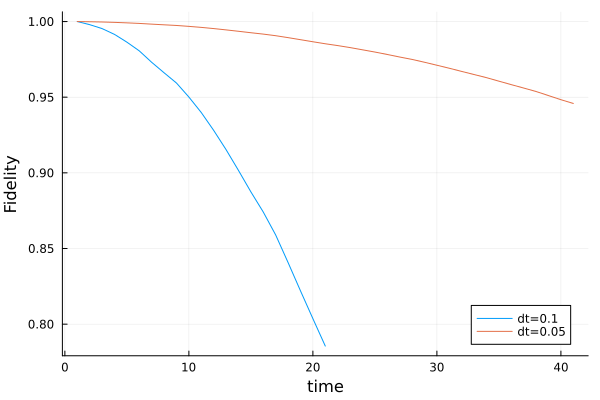

In [3]:
function first_order_fidelity(h2::AbstractMatrix, psi::MPS, dt::Real, T::Int64)
    s = siteinds(psi)
    L = length(s)
    G = begin
        U = exp(-1im * dt/2 * h2)
        l1 = [mat2op(U, s[i], s[i+1], s[i+2]) for i in 1:L-2]
        [l1; reverse(l1)]
    end
    ts = 0:dt:T
    fed = zeros(T+1)
    fed[1] = dot(vt[:, 1], mps2vec(psi)) |> abs2
    Nc = round(Int, 1/dt)
    for i in 1:length(ts)+1
        psi = apply(G, psi)
        a, b = divrem(i, Nc)
        if iszero(b)
            normalize!(psi)
            fed[1+a] = dot(vt[:, 1+a], mps2vec(psi)) |> abs2
        end
    end
    fed
end

psi = productMPS(s, [isodd(i) ? "Up" : "Dn" for i in 1:L])

f1 = first_order_fidelity(h2, psi, 0.1, 20)
plot(f1, label="dt=0.1", xlabel="time", ylabel="Fidelity")

f2 = first_order_fidelity(h2, psi, 0.05, 40)
plot!(f2, label="dt=0.05", xlabel="time", ylabel="Fidelity")

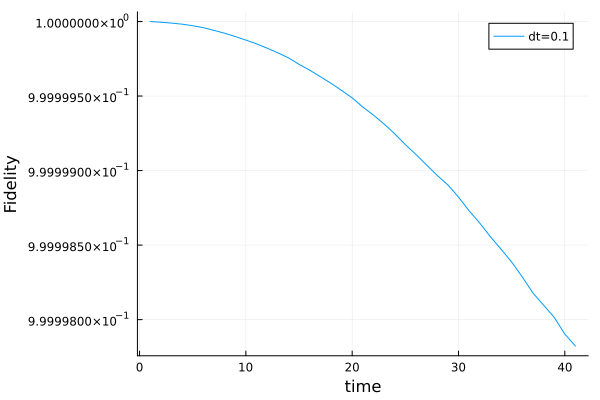

In [6]:
function fourth_order_fidelity(h2::AbstractMatrix, psi::MPS, dt::Real, T::Int64)
    s = siteinds(psi)
    L = length(s)
    
    G = tebd4(fill(h2, L-2), s, -1im*dt)
    ts = 0:dt:T
    fed = zeros(T+1)
    fed[1] = dot(vt[:, 1], mps2vec(psi)) |> abs2
    Nc = round(Int, 1/dt)
    for i in 1:length(ts)+1
        psi = apply(G, psi)
        a, b = divrem(i, Nc)
        if iszero(b)
            normalize!(psi)
            fed[1+a] = dot(vt[:, 1+a], mps2vec(psi)) |> abs2
        end
    end
    fed
end

f14 = fourth_order_fidelity(h2, psi, 0.1, 100)
plot(f14, label="dt=0.1", xlabel="time", ylabel="Fidelity")

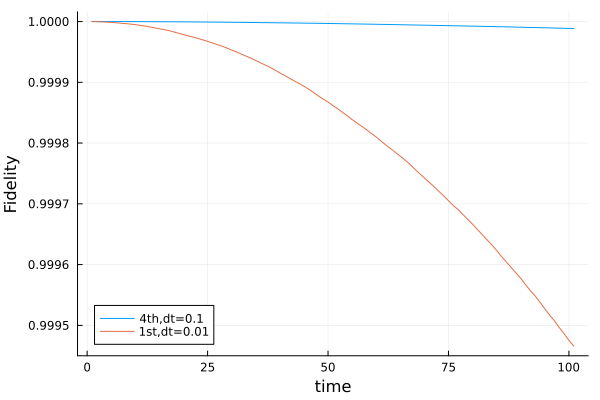

In [8]:
f14 = fourth_order_fidelity(h2, psi, 0.1, 100)
plot(f14, label="4th,dt=0.1", xlabel="time", ylabel="Fidelity")
f2 = first_order_fidelity(h2, psi, 0.01, 100)
plot!(f2, label="1st,dt=0.01", xlabel="time", ylabel="Fidelity")